In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sqlite3
import seaborn as sns

sns.set(style='white', palette="Set2", color_codes=False)
sns.set_style("ticks")

%matplotlib inline

In [2]:
def get_dataframes(query, databases):
    dataframes = []
    for database in databases:
        db = sqlite3.connect(database)
        dataframes += [pd.read_sql_query(query, db)]
    return pd.concat(dataframes)

In [3]:
query = 'select executor, tasks_per_trial, returned, start_submit, connected_workers, tag from tasks'
databases = [             
             'batch-dials.db'
             ]
tasks = get_dataframes(query, databases)
tasks.head()

,executor,tasks_per_trial,returned,start_submit,connected_workers,tag
0,funcx_local,1,1.554847e+09,1.554847e+09,1,bash_dials_1
1,funcx_local,1,1.554847e+09,1.554847e+09,1,bash_dials_2
2,funcx_local,1,1.554847e+09,1.554847e+09,1,bash_dials_4
3,funcx_local,1,1.554847e+09,1.554847e+09,1,bash_dials_8
4,funcx_local,1,1.554847e+09,1.554847e+09,1,bash_dials_16


In [4]:
tasks['completion time'] = tasks['returned'] - tasks['start_submit']
tasks['batch size'] = tasks['tag'].str.split('_').str[-1].map(int)
tasks['individual completion time'] = tasks['completion time'] / tasks['batch size']
tasks['app'] = tasks['tag'].str.split('_').str[:2].str.join('_')
tasks.head()

,executor,tasks_per_trial,returned,start_submit,connected_workers,tag,completion time,batch size,individual completion time,app
0,funcx_local,1,1.554847e+09,1.554847e+09,1,bash_dials_1,2.067592,1,2.067592,bash_dials
1,funcx_local,1,1.554847e+09,1.554847e+09,1,bash_dials_2,6.274843,2,3.137422,bash_dials
2,funcx_local,1,1.554847e+09,1.554847e+09,1,bash_dials_4,6.267858,4,1.566964,bash_dials
3,funcx_local,1,1.554847e+09,1.554847e+09,1,bash_dials_8,6.502706,8,0.812838,bash_dials
4,funcx_local,1,1.554847e+09,1.554847e+09,1,bash_dials_16,8.422429,16,0.526402,bash_dials


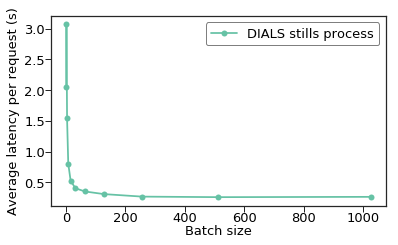

In [12]:
labels = {
    'bash_dials': 'DIALS stills process'   
}
fig, ax = plt.subplots(1, 1, figsize=(6,3.5))
markers = ['o', 's', 'p', '^', 'd', 'X']
marker_sizes = [6, 7, 7, 7, 7, 7, 6]
for i, app in enumerate(tasks['app'].unique()):
    cuts = (tasks['app'] == app) 
    df = tasks[cuts]
    if len(df) == 0: continue
    means = df.groupby('batch size', as_index=False).mean().sort_values('batch size')
    means.plot('batch size', 'individual completion time', marker=markers[i], ms=marker_sizes[i], 
               logy=False, logx=False, 
               #color=colors[i], 
               label=labels[app], ax=ax) # , yerr=list(standard_deviations['completion time'])


    #ax.set_ylim([1, 1000])
    #ax.set_xlim(10, 100000)
    ax.set_ylabel('Average latency per request (s)', fontsize=13, color='black')
    ax.set_xlabel('Batch size', labelpad=0, fontsize=13, color='black')
    ax.get_legend().remove()
    ax.tick_params(axis='y', which='minor')
    ax.tick_params(axis='both', which='major', pad=0, labelsize=13, labelcolor='black')

    plt.tick_params(axis='both', which='major', pad=0, labelsize=13, labelcolor='black')
    #legend = plt.legend(loc='center left', bbox_to_anchor=(0.8, 0.5), frameon=True, fontsize=13)
    legend = plt.legend(loc='best', 
                        ncol=1, 
                        #bbox_to_anchor=(-2.7, 1.2), 
                        fancybox=True, frameon=True, fontsize=13, framealpha=0.5)
    plt.setp(legend.get_texts(), color='black')
    legend.get_frame().set_edgecolor('black')
    legend.get_frame().set_linewidth(1)
    plt.subplots_adjust(wspace=0.2, hspace=0)

    plt.savefig('png/batching.png', bbox_inches = "tight", dpi=1000)
